In [3]:
! pip install numpy==1.19.0
! pip install pandas==1.4.0
! pip install matplotlib==3.6.1
! pip install seaborn==0.12.0
! pip install scipy==1.9.2
! pip install mycolorpy==1.5.1
! pip install smartprint==1.0.5

import os
from os import path
import pickle as pk
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind
from smartprint import smartprint as sprint
plt.rcParams.update({"font.size": 18})

In [7]:
! bash ../split_train_val.sh

### Analyze feature differences over daytimes

os.popen('wc -l ' + fname).read() :   141121 feature_importance_max_25x25_val.csv



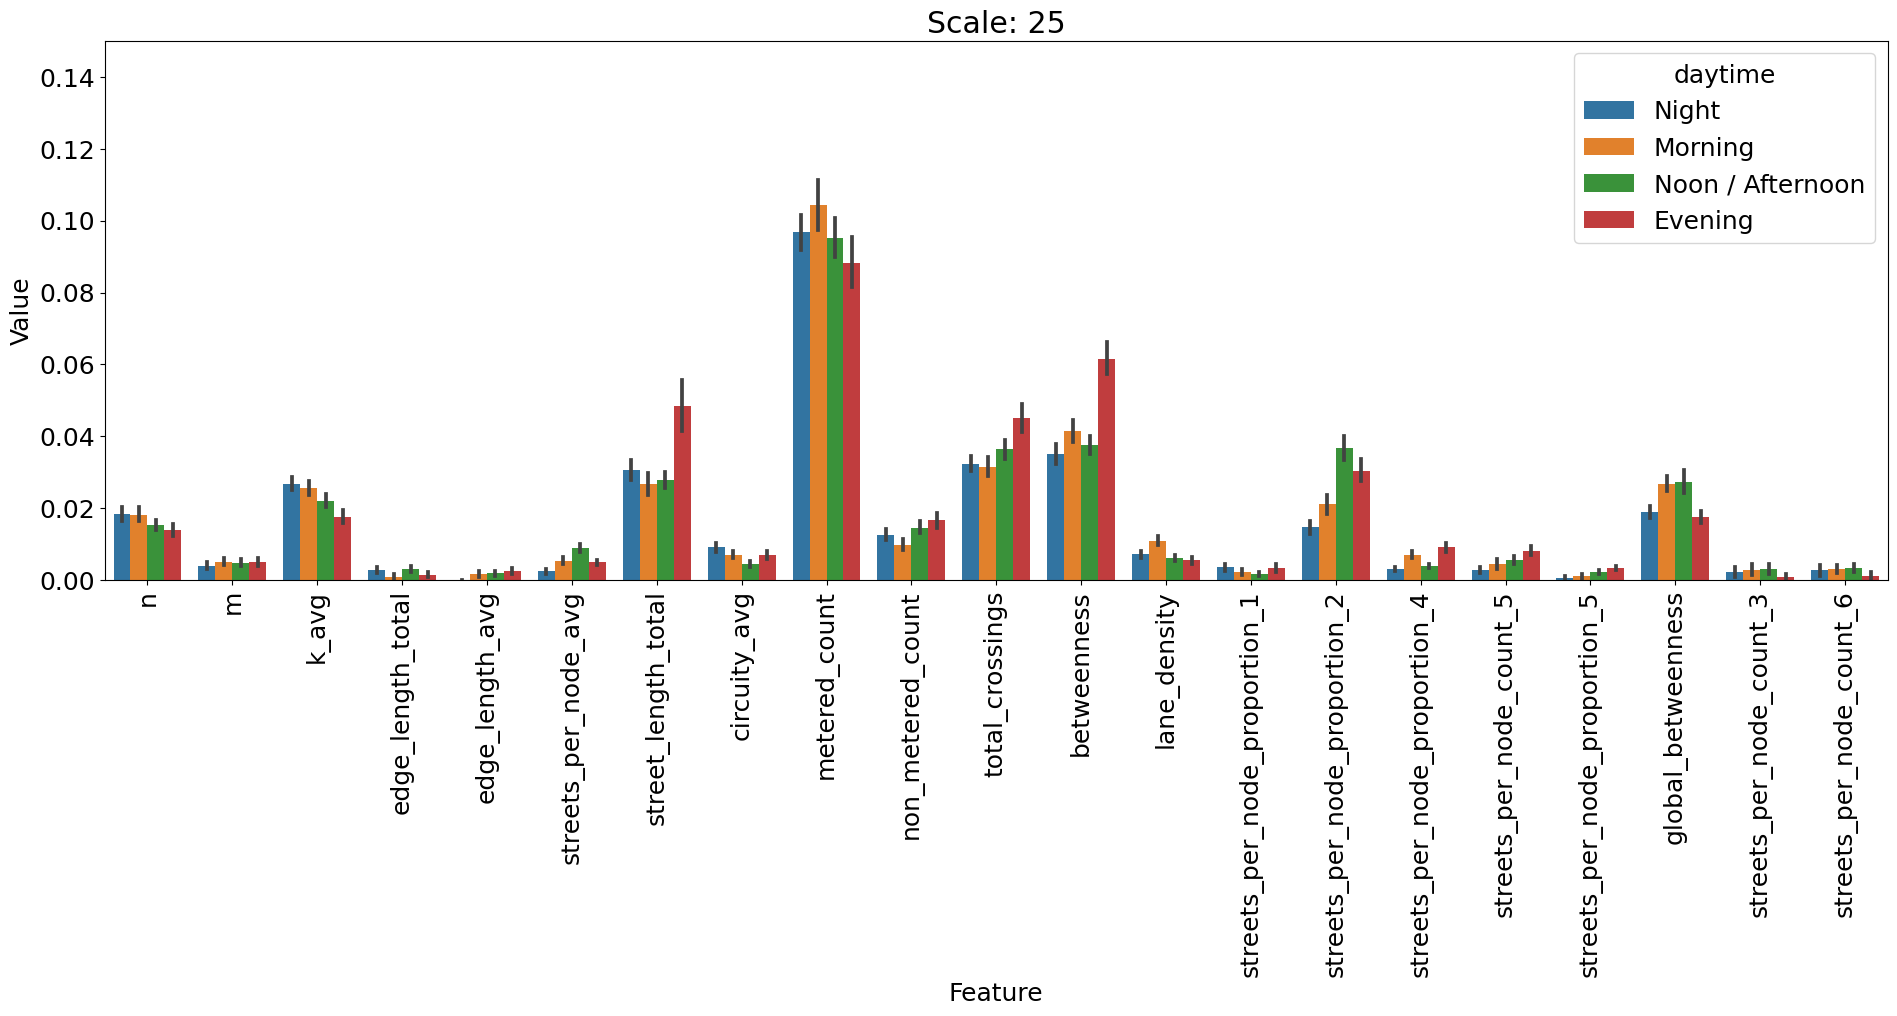

os.popen('wc -l ' + fname).read() :   138241 feature_importance_max_50x50_val.csv



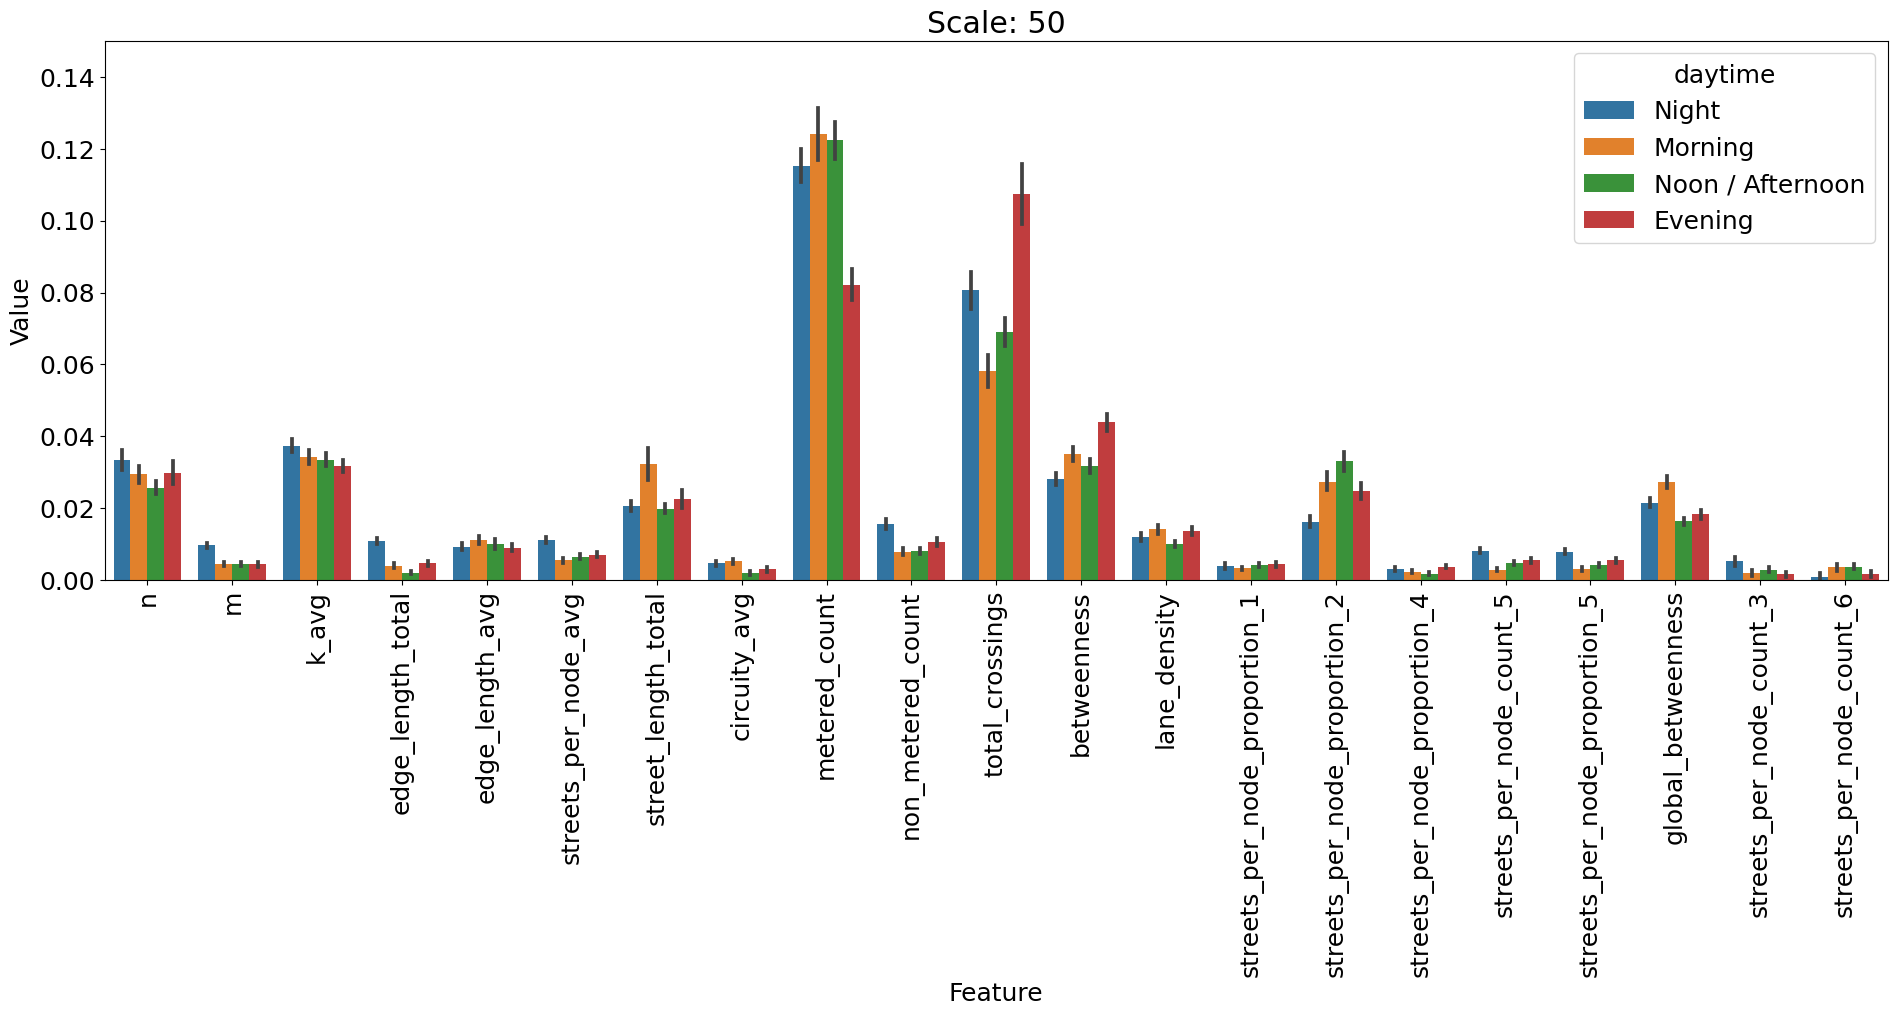

In [61]:
# add a new columns that simplifies the TOD
def new_datetime(x):
    if x < 6 or x > 21:
        return "Night"
    if x >= 6 and x <= 10:
        return "Morning"
    if x > 10 and x <= 16:
        return "Noon / Afternoon"
    if x > 16 and x <= 21:
        return "Evening"
        
for scale in [25, 50]:
    fname = "feature_importance_max_" + str(scale) + "x" + str(scale) + "_val.csv" 
    sprint (os.popen('wc -l ' + fname).read())
    data = pd.read_csv(fname)
    data["daytime"] = data["TOD"].apply(new_datetime)
    plt.figure(figsize=(23, 7))
    ax = sns.barplot(data=data, x="Feature", y="Value", hue="daytime")
    plt.xticks(np.arange(data["Feature"].nunique()), data["Feature"].unique(), rotation=90)
    plt.ylim(0, 0.15)
    plt.title("Scale: " + str(scale) )
    plt.show()

#### Check for significances

In [62]:
# you can vary the daytimes here that you want to compare
time1 = "Morning"
time2 = "Evening"

for scale in [25, 50, 100]:
    fname = "feature_importance_max_" + str(scale) + "x" + str(scale) + "_val.csv" 
    sprint (scale)
    data = pd.read_csv(fname)
    data["daytime"] = data["TOD"].apply(new_datetime)
    
    print(f"Difference between {time1} and {time2} is significant for features ...\n")
    for feat in data["Feature"].unique():
        time1_df = data[(data["Feature"] == feat) & (data["daytime"] == time1)]
        time2_df = data[(data["Feature"] == feat) & (data["daytime"] == time2)]
        t_res = ttest_ind(time1_df["Value"], time2_df["Value"])
        if t_res[1] < 0.05:
            print(feat)

scale : 25
Difference between Morning and Evening is significant for features ...

n
k_avg
street_length_total
metered_count
non_metered_count
total_crossings
betweenness
lane_density
streets_per_node_proportion_2
streets_per_node_proportion_4
streets_per_node_count_5
streets_per_node_proportion_5
global_betweenness
streets_per_node_count_3
streets_per_node_count_6
scale : 50
Difference between Morning and Evening is significant for features ...

edge_length_avg
streets_per_node_avg
street_length_total
circuity_avg
metered_count
non_metered_count
total_crossings
betweenness
streets_per_node_proportion_1
streets_per_node_proportion_4
streets_per_node_count_5
streets_per_node_proportion_5
global_betweenness
streets_per_node_count_6
scale : 100
Difference between Morning and Evening is significant for features ...

n
m
k_avg
edge_length_avg
streets_per_node_avg
street_length_total
circuity_avg
non_metered_count
total_crossings
betweenness
lane_density
streets_per_node_proportion_1
streets

In [63]:
# add a new columns that simplifies the TOD
def new_datetime(x):
    if (x >= 6 and x <= 10) or (x >= 16 and x < 19):
        return "Peak"
    else:
        return "Off Peak"

# you can vary the daytimes here that you want to compare
time1 = "Peak"
time2 = "Off Peak"

for scale in [25, 50, 100]:
    fname = "feature_importance_max_" + str(scale) + "x" + str(scale) + "_val.csv" 
    print( "......................" )
    sprint (scale)
    data = pd.read_csv(fname)
    data["daytime"] = data["TOD"].apply(new_datetime)
    
    print(f"Difference between {time1} and {time2} is significant for features ...\n")
    for feat in data["Feature"].unique():
        time1_df = data[(data["Feature"] == feat) & (data["daytime"] == time1)]
        time2_df = data[(data["Feature"] == feat) & (data["daytime"] == time2)]
        t_res = ttest_ind(time1_df["Value"], time2_df["Value"])
        if t_res[1] < 0.05:
            print(feat)

......................
scale : 25
Difference between Peak and Off Peak is significant for features ...

edge_length_total
edge_length_avg
streets_per_node_avg
street_length_total
circuity_avg
non_metered_count
lane_density
streets_per_node_proportion_4
streets_per_node_count_5
global_betweenness
......................
scale : 50
Difference between Peak and Off Peak is significant for features ...

n
m
edge_length_total
streets_per_node_avg
street_length_total
metered_count
non_metered_count
total_crossings
betweenness
lane_density
streets_per_node_proportion_1
streets_per_node_proportion_2
streets_per_node_count_5
streets_per_node_proportion_5
global_betweenness
streets_per_node_count_3
streets_per_node_count_6
......................
scale : 100
Difference between Peak and Off Peak is significant for features ...

m
k_avg
edge_length_total
edge_length_avg
streets_per_node_avg
street_length_total
circuity_avg
metered_count
non_metered_count
total_crossings
lane_density
streets_per_node_

### Idea: analyze the time-dependency of each feature

One idea would be to compute the "time dependency" of a feature, for example by taking the variance over time (and maybe normalizing by the general variance over PlotCounter for that feature). Then one could report which features of the street network have very time-dependent influence on congestion and which ones in general.

## Flexible plotting function: Compare some columns and filter others

In [64]:
from matplotlib.lines import Line2D
from mycolorpy import colorlist as mcp

def plot_configurations(
    all_results,
    col_xaxis="TOD", # on the x axis, can either plot time or scale
    compare_col="Feature", # This is the column that will be COLOURED
    compare_second_level="Marker", # This is the column that will be shown by MARKERSTYLE (dotted / normal line)
    eval_col="Value", # This will be shown on the y axis
    agg_method="mean", # how to aggregate the values over the remaining columns
    out_path=None, # specify a path if you want to save the ifgure
    filter_columns = {}, # We can filter for certain columns
    title="default"
):
    """Flexible code to filter for some columns and plot for others"""
    
    assert compare_col not in filter_columns.keys() and compare_second_level not in filter_columns.keys()
    print(
        "Aggregating over",
        [
            col
            for col in all_results.columns
            if col not in filter_columns.keys() and col != compare_col and col != compare_second_level and col!= col_xaxis and col!= eval_col

        ],
    )

    # filter by all settings in filter_columns
    results_filtered = all_results.copy()
    for key, val in filter_columns.items():
        results_filtered = results_filtered[results_filtered[key] == val]

    # group by the relevant columns
    results_grouped = (
        results_filtered.groupby([col_xaxis, compare_col, compare_second_level])
        .agg({eval_col: agg_method})
        .reset_index()
    )

    # print(results_grouped)
    plot_lines = []
    # styles = ["-", "--", "-.", ":"]
    styles = ["-", "-.", "--", ":"]

    cols =  mcp.gen_color(cmap='plasma', n=all_results[compare_col].nunique())
    plt.figure(figsize=(9, 7))
    for i, uni_val in enumerate(results_filtered[compare_col].unique()):
        plot_lines_innter = []
        for j, uni_val_2 in enumerate(results_filtered[compare_second_level].unique()):
            cond1 = results_grouped[compare_col] == uni_val
            cond2 = results_grouped[compare_second_level] == uni_val_2
            results_sub = results_grouped[cond1 & cond2]
            col = "grey" if uni_val == "random" else cols[i]
            (l1,) = plt.plot(
                results_sub[col_xaxis],
                results_sub[eval_col], # np.log2(
                c=col,
                linestyle=styles[j],
                label=f"{uni_val}_{uni_val_2}",
            )
                
            plot_lines_innter.append(l1)
        plot_lines.append(plot_lines_innter)

    black_lines = []
    for orig_line in plot_lines[0]:
        l1 = Line2D([], [])
        l1.update_from(orig_line)
        l1.set_color("black")
        black_lines.append(l1)
        
    try:
        _ = int(results_sub[col_xaxis][0])
    except:
        plt.xticks(rotation=90)
    
    legend1_location = (0.25, 0.75)
    legend1 = plt.legend(
        black_lines,
        results_filtered[compare_second_level].unique(),
        # bbox_to_anchor=legend1_location,
        loc = "best",
#         loc = "upper left", # FOR YUMUV INSTEAD OF BOUNDING BOX
        title=compare_second_level.replace("_", " ") # .capitalize(),
    )
    plt.ylim(0, None) # FOR YUMUV: upper limit 0.11
    legend_location = "best" 
    plt.ylabel(eval_col)
    plt.xlabel(col_xaxis)
    plt.legend(
        [l[0] for l in plot_lines],
        results_filtered[compare_col].unique(),
        # loc=legend_location,
        loc = "best",
        title=compare_col.replace("_", " ").capitalize(), fontsize=10
    )
    plt.gca().add_artist(legend1)
    filtered_keys = "_".join([str(elem) for elem in filter_columns.values()])
    plt.title(title)
    plt.tight_layout()
    if out_path is not None:
        plt.savefig(out_path)
    else:
        plt.show()
    

### Example usage of this plotting function:

For example, we filter for the city of Singapore, plot the feature importance by TOD, and distingish train and val

Aggregating over ['Scale', 'PlotCounter', 'daytime']


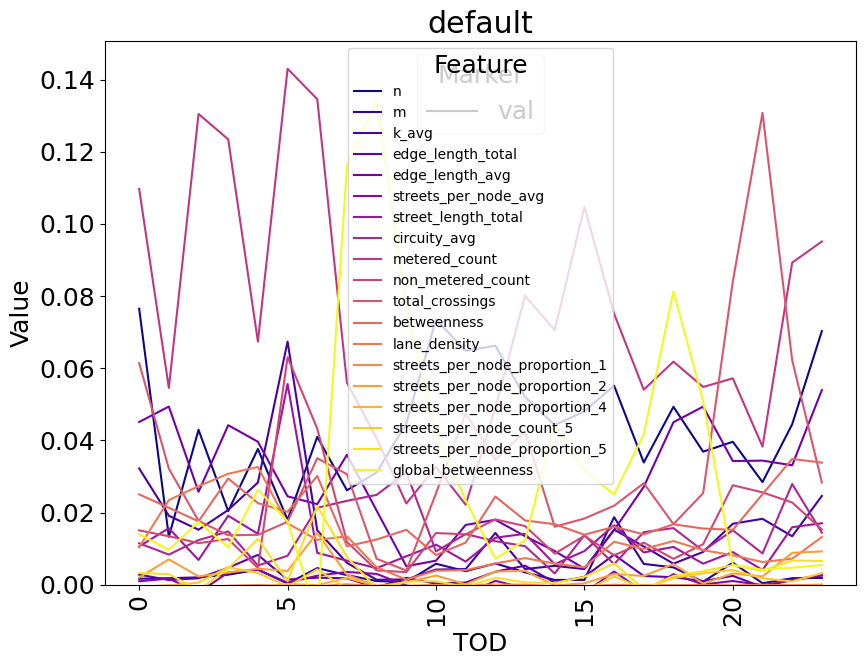

In [65]:
plot_configurations(
    data,
    col_xaxis="TOD", # on the x axis, can either plot time or scale
    compare_col="Feature", # This is the column that will be COLOURED
    compare_second_level="Marker", # This is the column that will be shown by MARKERSTYLE (dotted / normal line)
    eval_col="Value", # This will be shown on the y axis
    agg_method="mean", # how to aggregate the values over the remaining columns
    filter_columns = {"CityName": "Singapore"}
)

In the same manner, we could show the scale on the x axis

### Plotting the features in batches

Aggregating over ['CityName', 'Scale', 'PlotCounter', 'daytime']


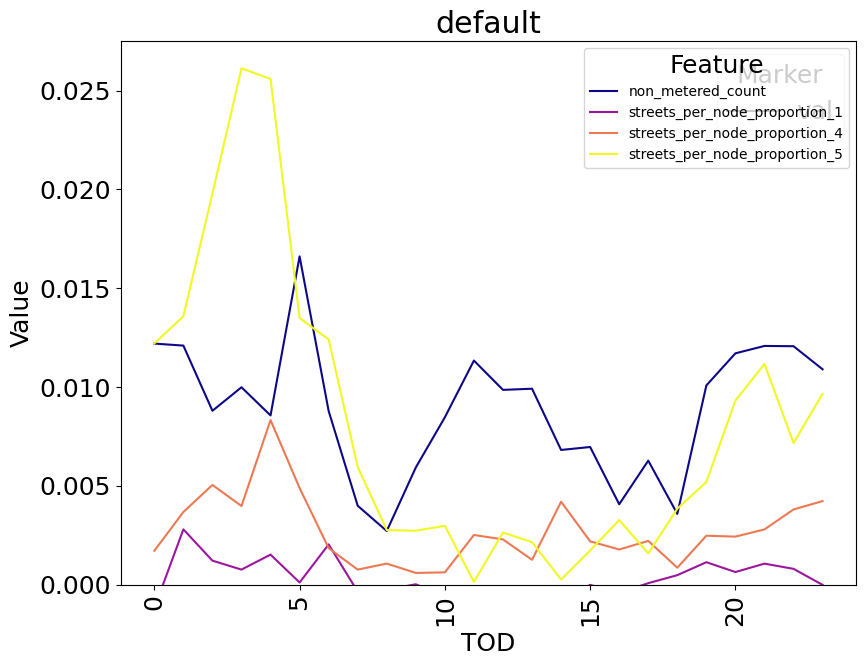

Aggregating over ['CityName', 'Scale', 'PlotCounter', 'daytime']


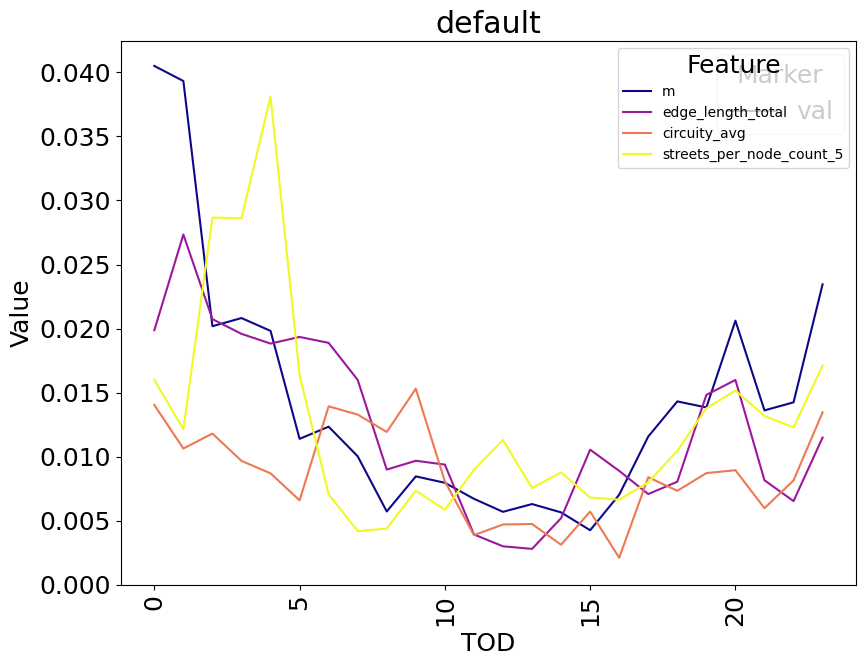

Aggregating over ['CityName', 'Scale', 'PlotCounter', 'daytime']


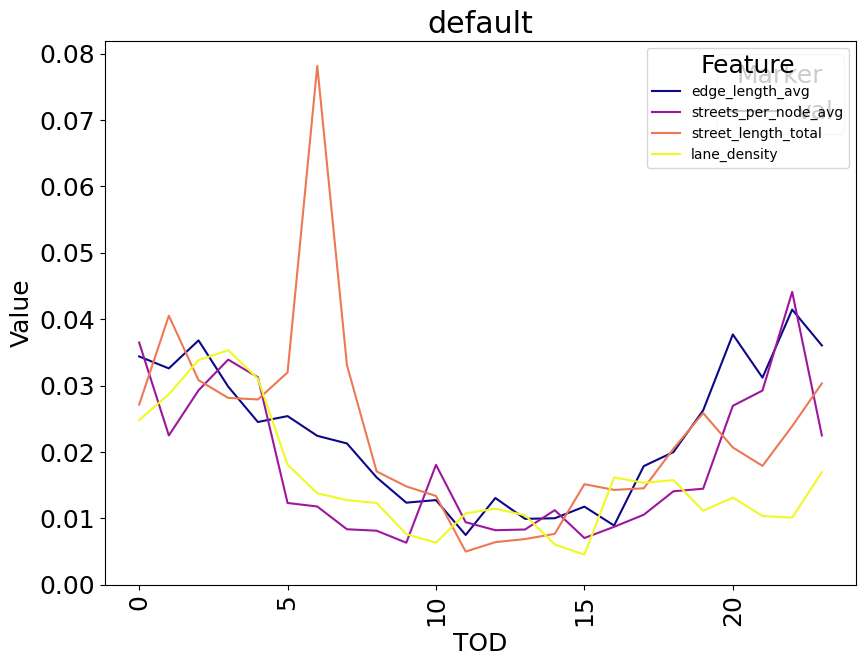

Aggregating over ['CityName', 'Scale', 'PlotCounter', 'daytime']


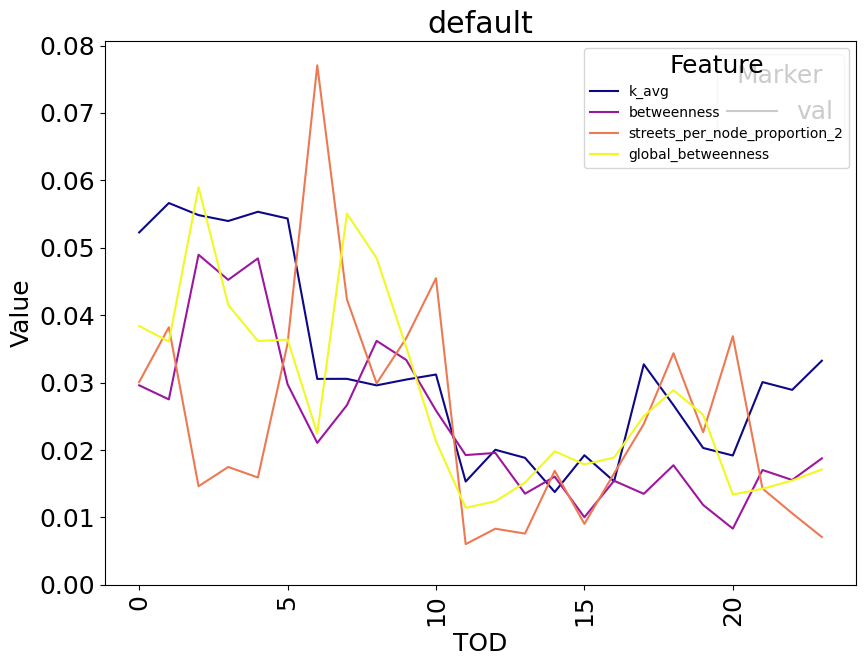

Aggregating over ['CityName', 'Scale', 'PlotCounter', 'daytime']


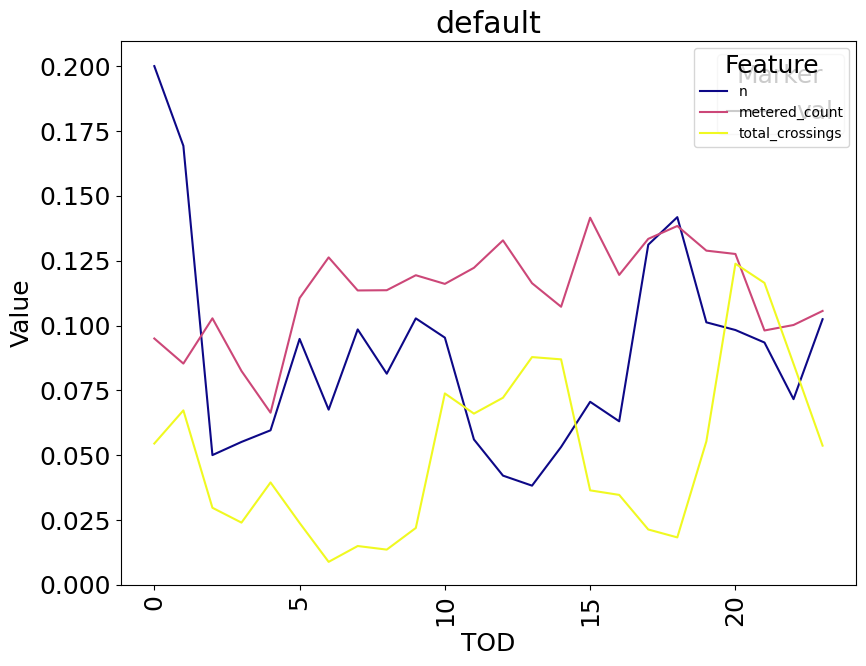

In [66]:
sorted_feat_cols = data.groupby("Feature")["Value"].mean().sort_values().index
for i in range(len(sorted_feat_cols)//4 + 1):
    plot_feats = sorted_feat_cols[i*4: (i+1)*4]
    data_plot = data[data["Feature"].isin(plot_feats)]
    plot_configurations(data_plot)

## Compare features by daytime

The plotting functions works also for categorical labels on the x axis

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


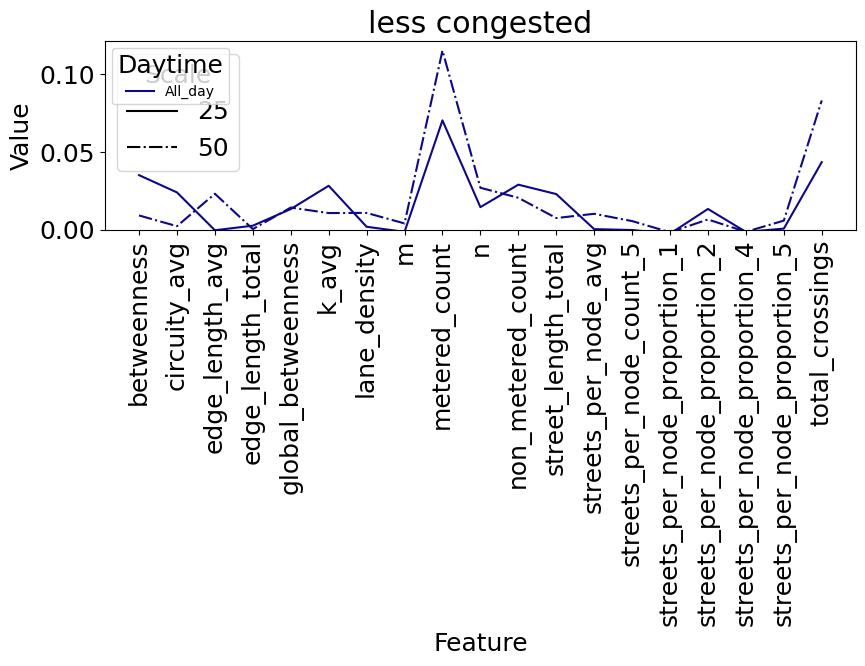

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


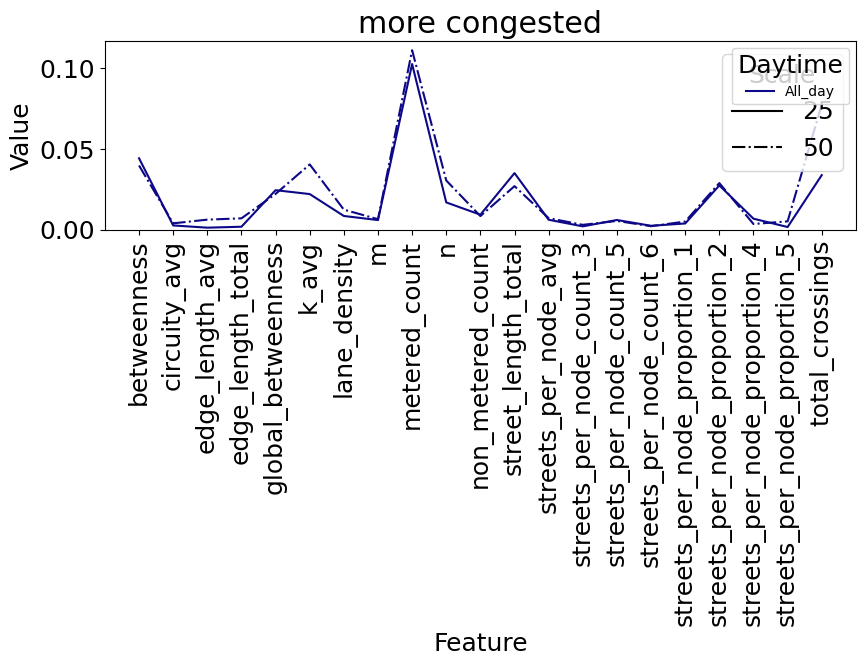

In [71]:
! head -n 1 feature_importance_max_50x50_val.csv > max_three_scales.csv
! tail -n +2 feature_importance_max_25x25_val.csv >> max_three_scales.csv
! tail -n +2 feature_importance_max_50x50_val.csv >> max_three_scales.csv
# ! tail -n +2 feature_importance_max_100x100_val.csv >> max_three_scales.csv

! head -n 1 max_three_scales.csv > less_congested_cities.csv
! grep -E "Singapore|Zurich" max_three_scales.csv >> less_congested_cities.csv

! head -n 1 max_three_scales.csv > highly_congested_cities.csv
! grep -E "Mumbai|Auckland|Istanbul|MexicoCity|Bogota|NewYorkCity|Capetown|London" max_three_scales.csv >> highly_congested_cities.csv

data = pd.read_csv("less_congested_cities.csv")
# data["daytime"] = data["TOD"].apply(new_datetime)
data["daytime"] = "All_day"
sorted_data = data.sort_values("Value")
plot_configurations(sorted_data, col_xaxis="Feature", compare_col="daytime", compare_second_level="Scale", title="less congested")

data = pd.read_csv("highly_congested_cities.csv")
# data["daytime"] = data["TOD"].apply(new_datetime)
data["daytime"] = "All_day"
sorted_data = data.sort_values("Value")
plot_configurations(sorted_data, col_xaxis="Feature", compare_col="daytime", compare_second_level="Scale", title="more congested")

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


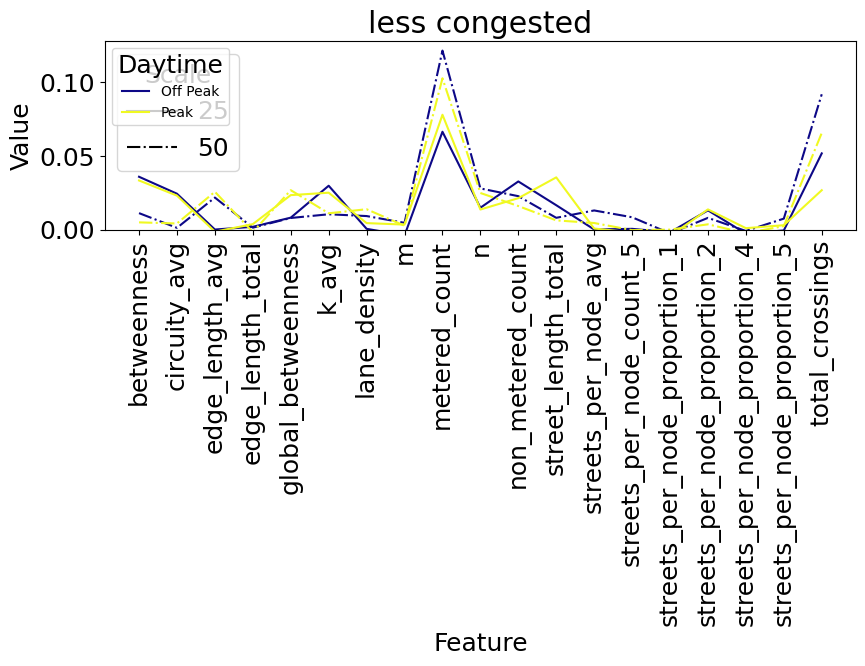

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


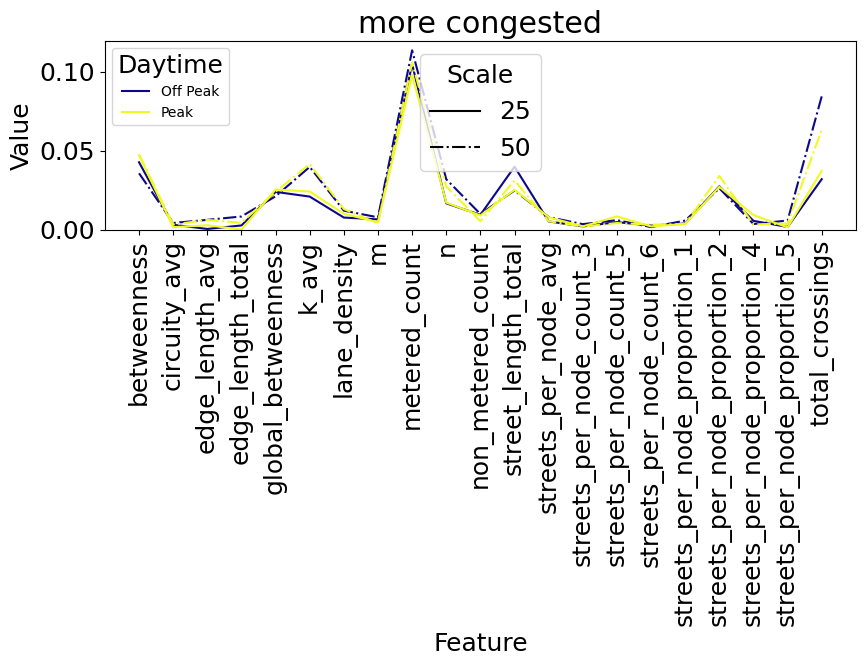

In [72]:
! head -n 1 feature_importance_max_50x50_val.csv > max_three_scales.csv
! tail -n +2 feature_importance_max_25x25_val.csv >> max_three_scales.csv
! tail -n +2 feature_importance_max_50x50_val.csv >> max_three_scales.csv
# ! tail -n +2 feature_importance_max_100x100_val.csv >> max_three_scales.csv

! head -n 1 max_three_scales.csv > less_congested_cities.csv
! grep -E "Singapore|Zurich" max_three_scales.csv >> less_congested_cities.csv

! head -n 1 max_three_scales.csv > highly_congested_cities.csv
! grep -E "Mumbai|Auckland|Istanbul|MexicoCity|Bogota|NewYorkCity|Capetown|London" max_three_scales.csv >> highly_congested_cities.csv

data = pd.read_csv("less_congested_cities.csv")
data["daytime"] = data["TOD"].apply(new_datetime)
sorted_data = data.sort_values("Value")
plot_configurations(sorted_data, col_xaxis="Feature", compare_col="daytime", compare_second_level="Scale", title="less congested")

data = pd.read_csv("highly_congested_cities.csv")
data["daytime"] = data["TOD"].apply(new_datetime)
sorted_data = data.sort_values("Value")
plot_configurations(sorted_data, col_xaxis="Feature", compare_col="daytime", compare_second_level="Scale", title="more congested")

### Further ideas:

* It would be important to show which features are consistently important across cities. If a feature is very important in some cities but not in others, it could be investigated why this happens.

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


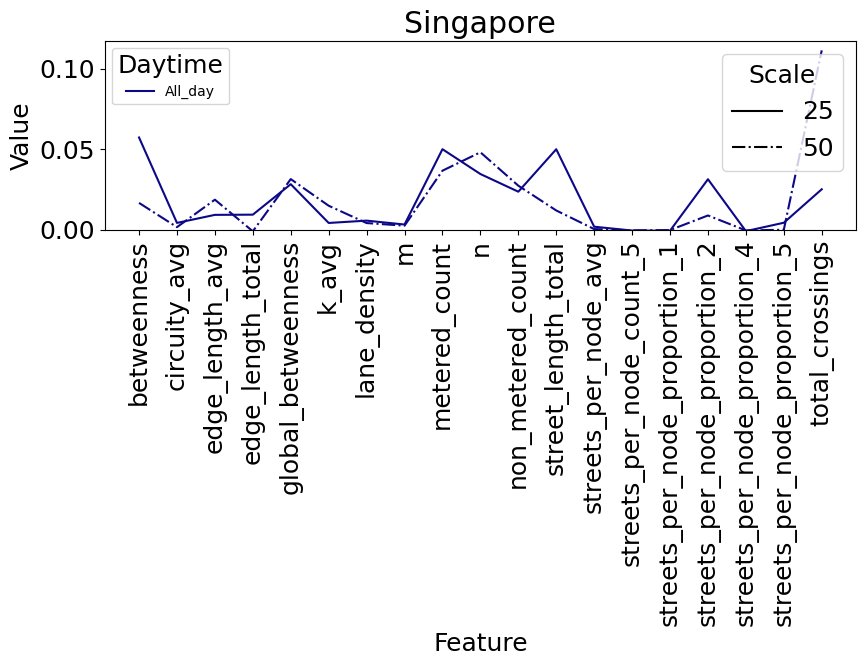

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


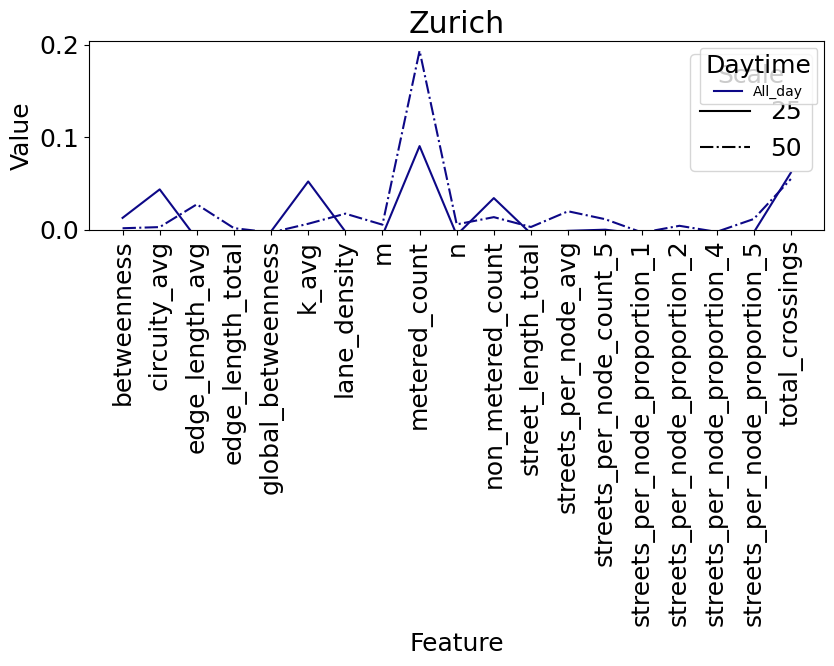

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


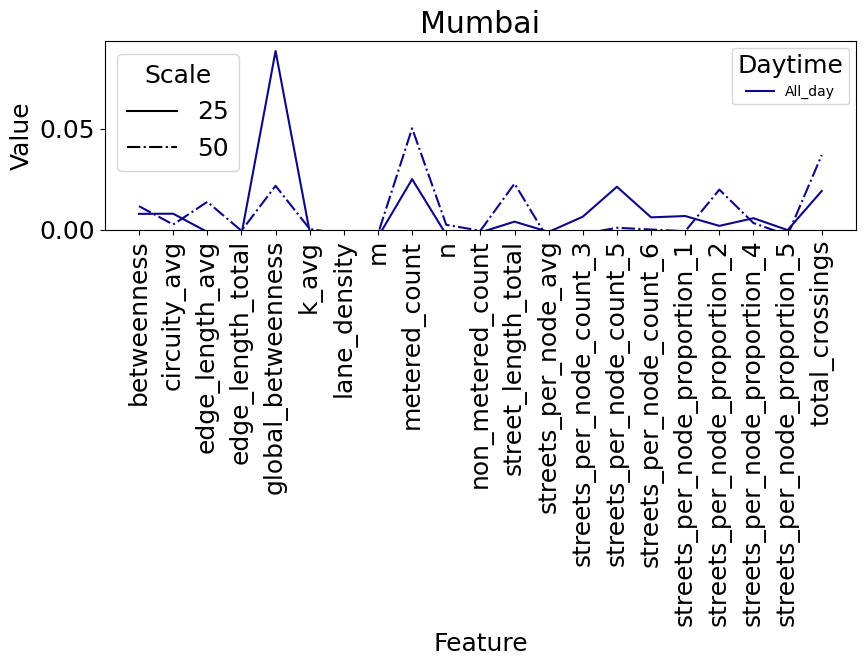

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


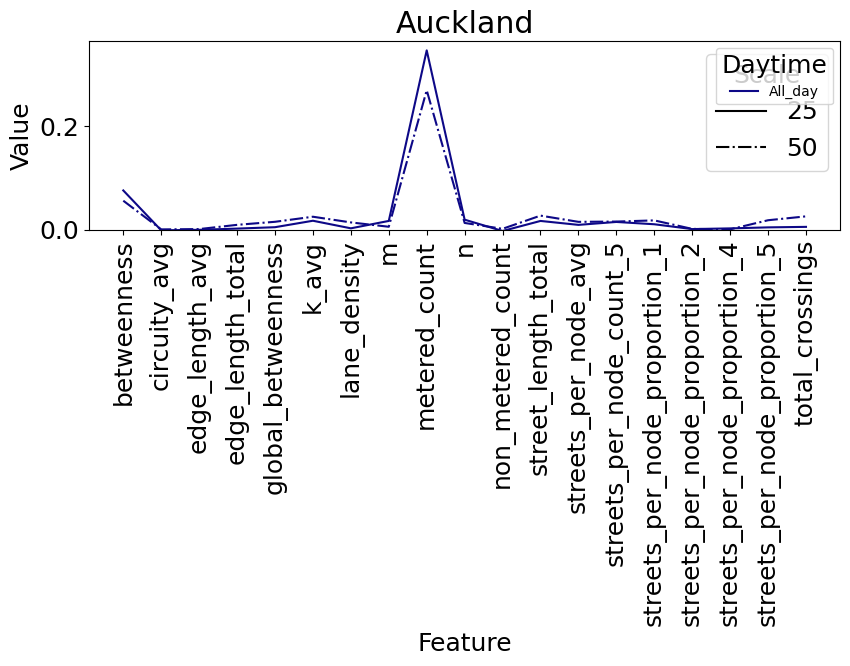

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


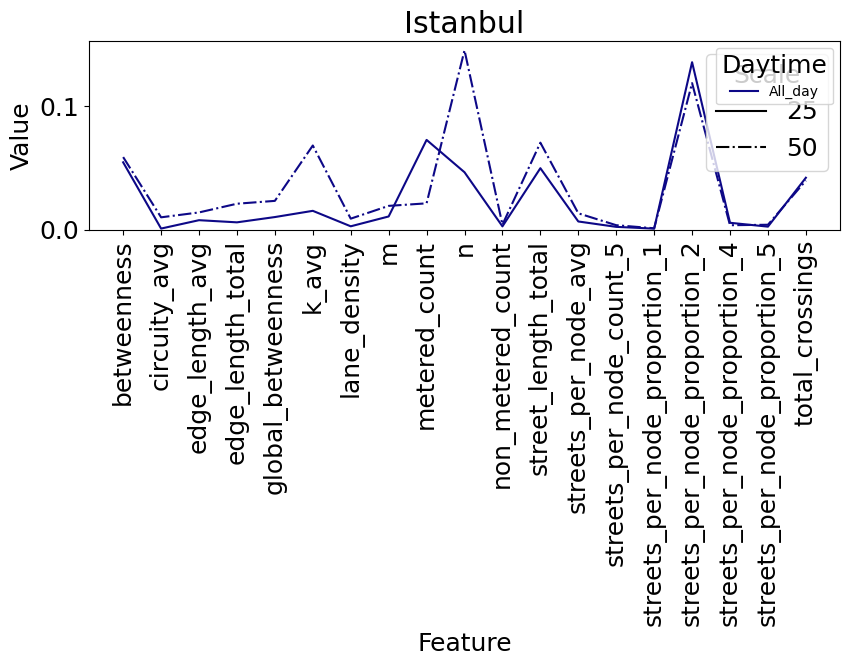

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


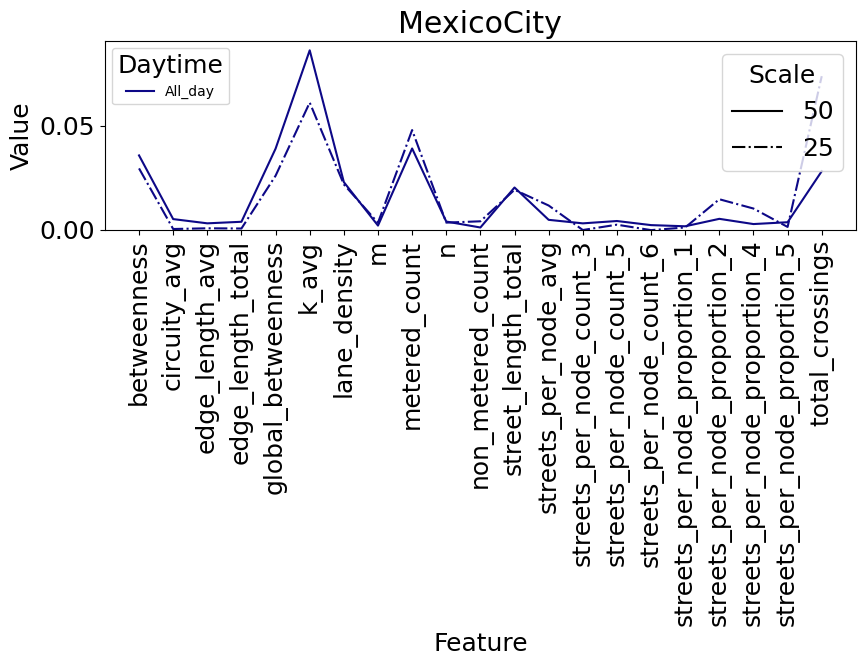

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


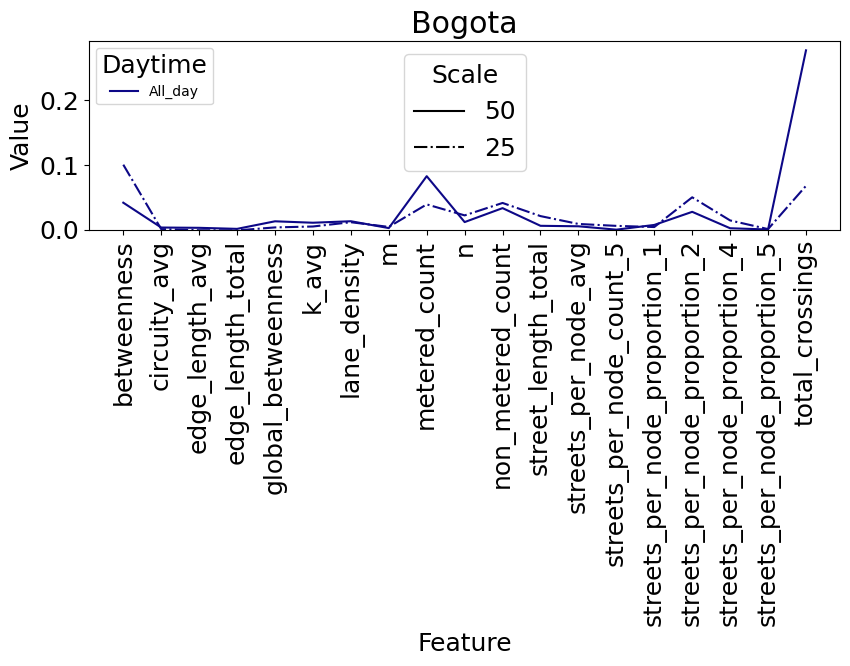

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


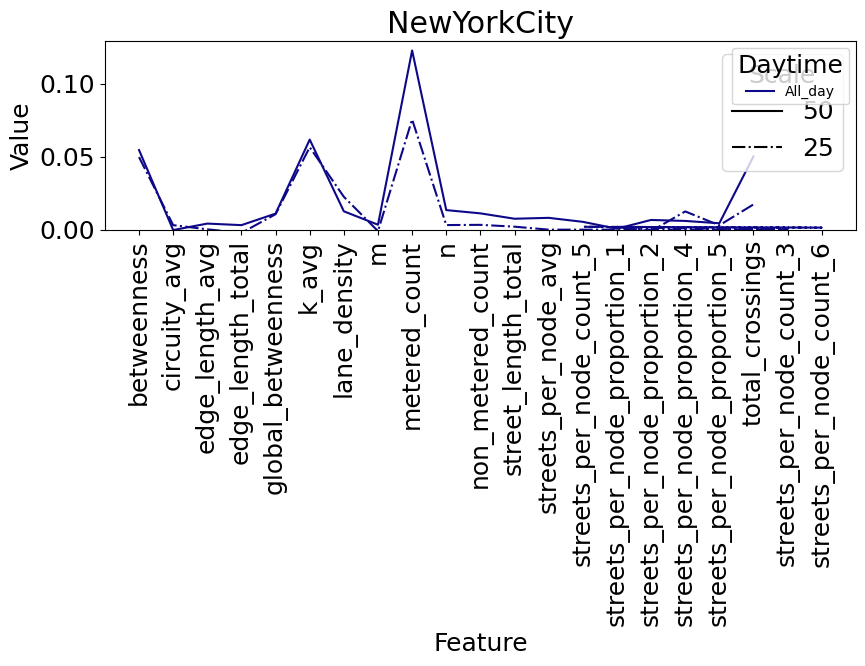

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


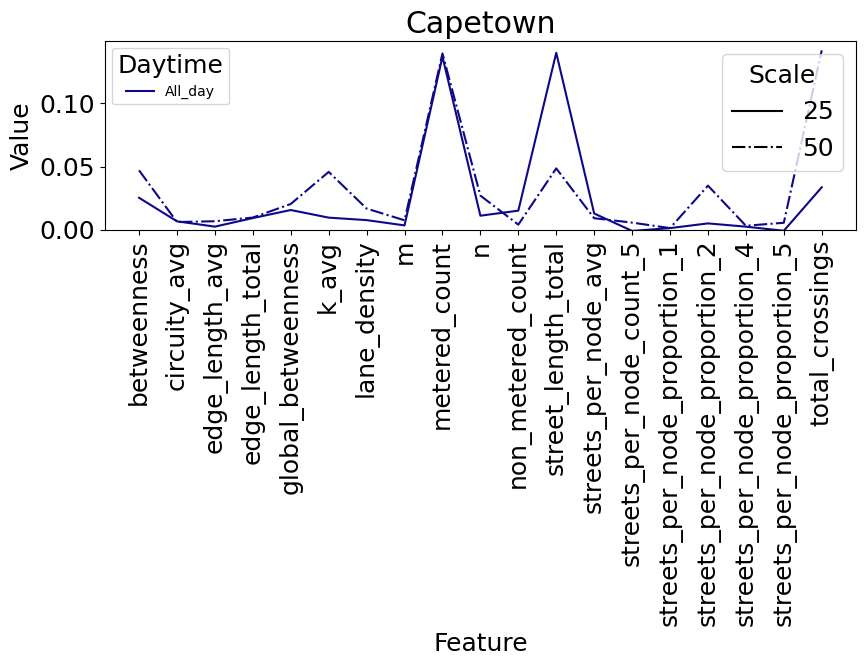

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


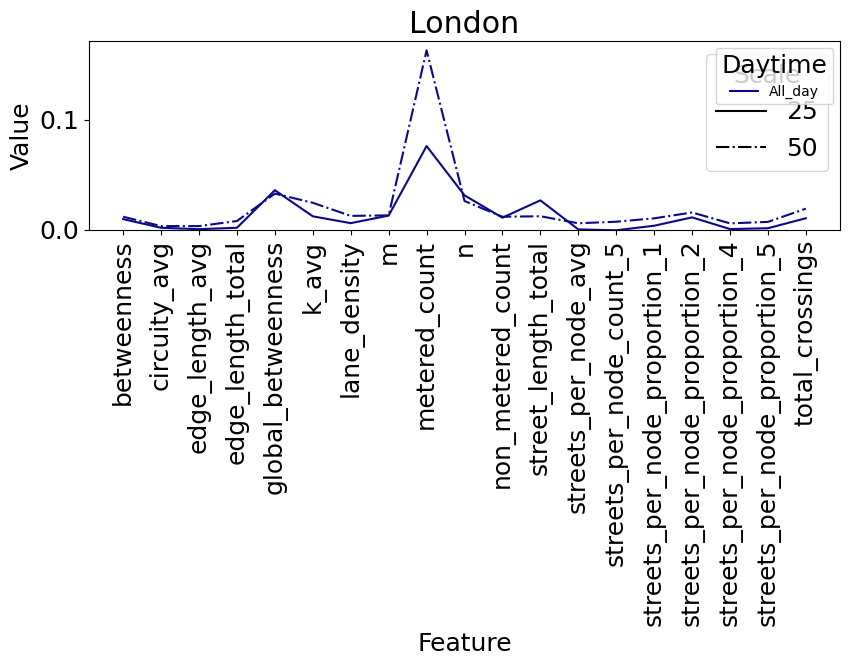

In [73]:
import pandas as pd

cities = [
    "Singapore", "Zurich", "Mumbai", "Auckland", "Istanbul", 
    "MexicoCity", "Bogota", "NewYorkCity", "Capetown", "London"
]

# Extract the header from mean_/ max three_scales.csv
with open("max_three_scales.csv", 'r') as main_file:
    header = main_file.readline().strip()

for city in cities:
    city_file = f"{city}_data.csv"
    
    # Extract relevant rows for the city
    with open("max_three_scales.csv", 'r') as main_file, open(city_file, 'w') as city_specific:
        for line in main_file:
            if city in line or header in line:
                city_specific.write(line)
    
    # Read the city-specific data into pandas
    data = pd.read_csv(city_file)
    
    # Update and sort data, then plot
    data["daytime"] = "All_day"
    sorted_data = data.sort_values("Value")
    plot_configurations(sorted_data, col_xaxis="Feature", compare_col="daytime", compare_second_level="Scale", title=city)


Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


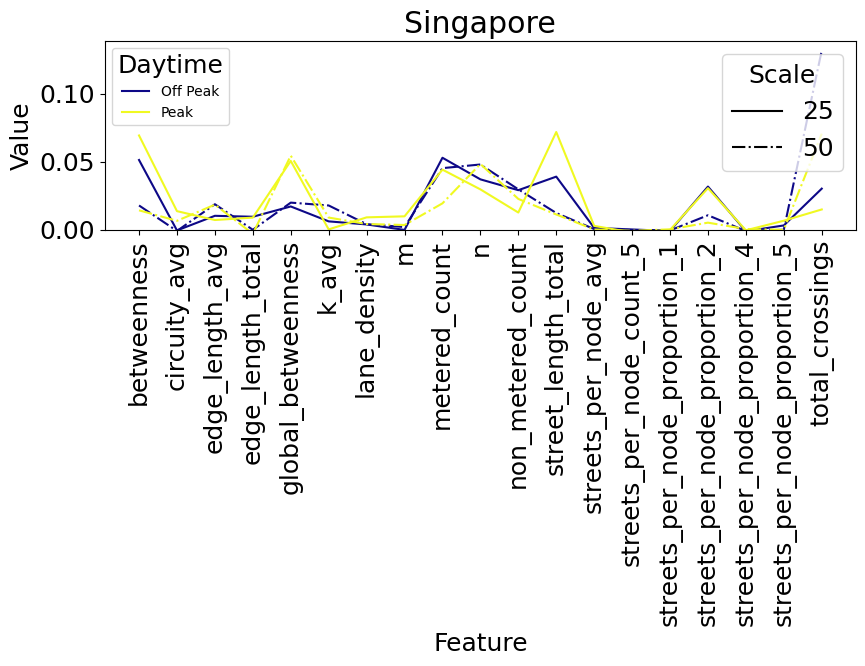

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


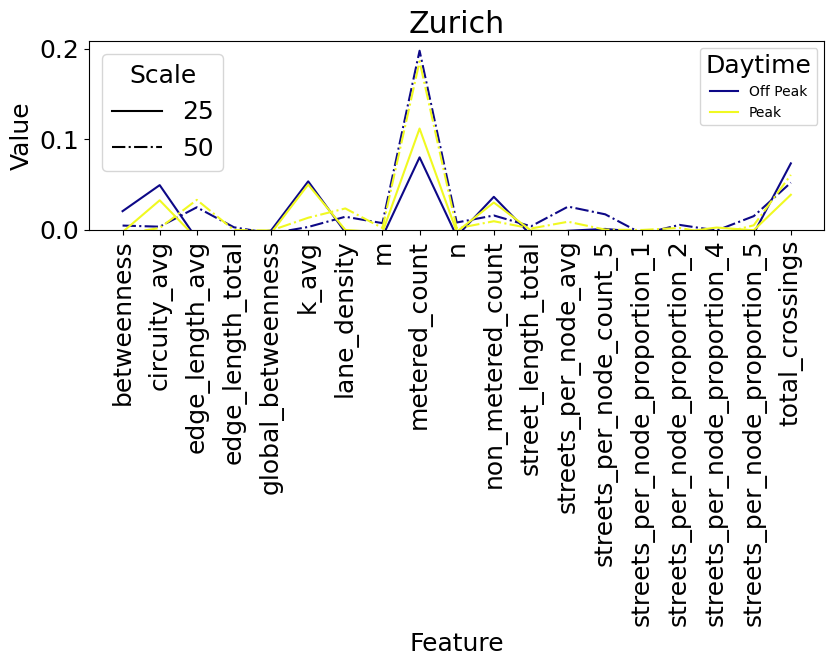

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


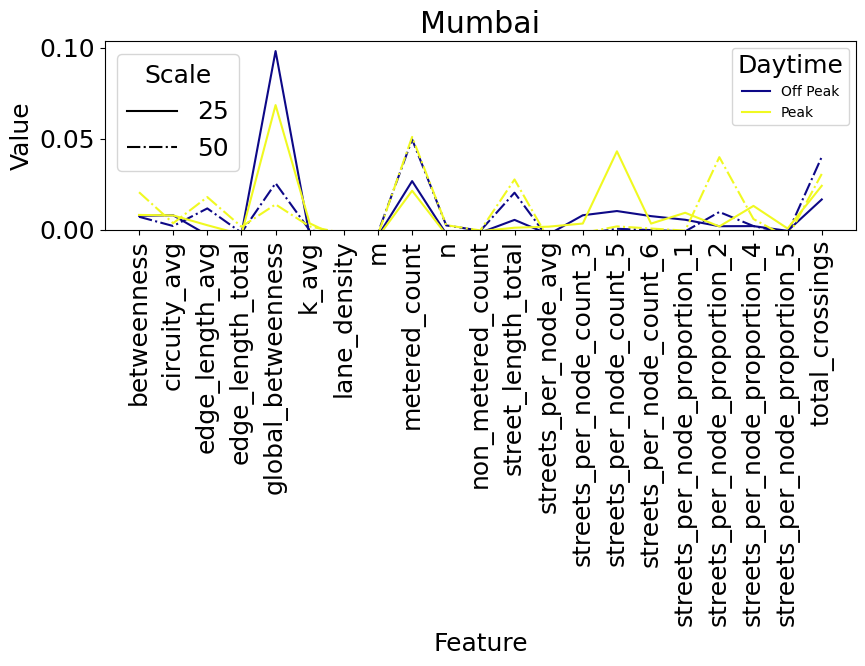

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


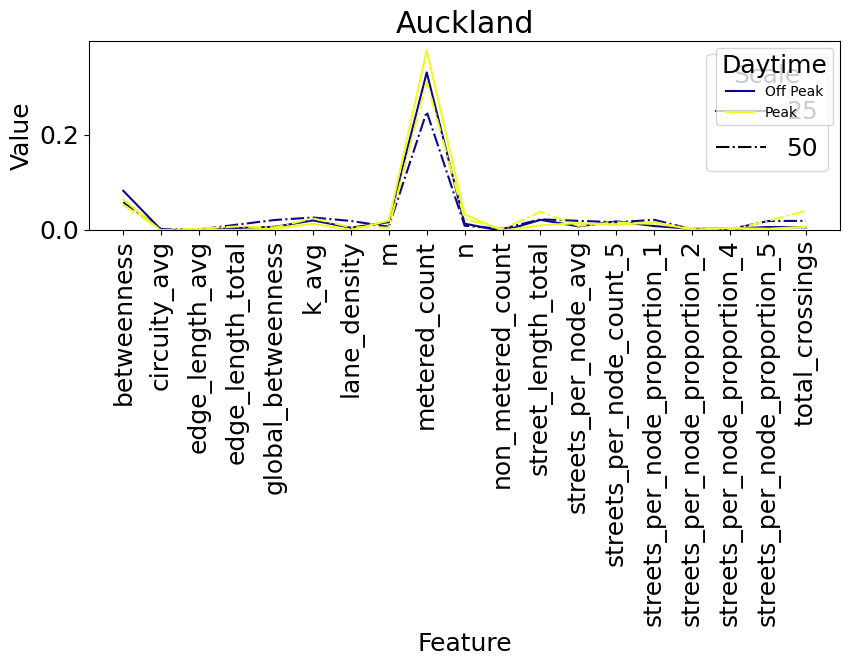

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


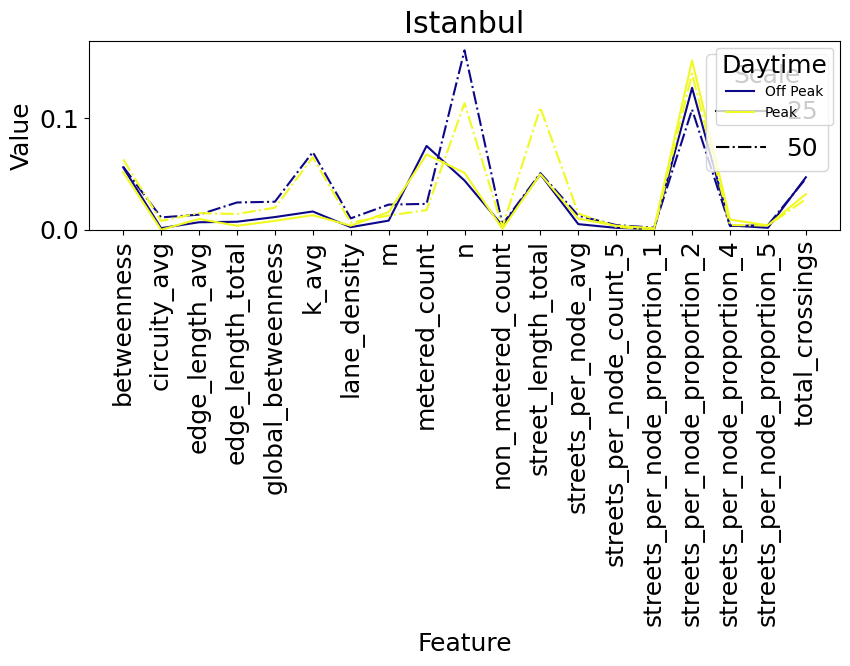

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


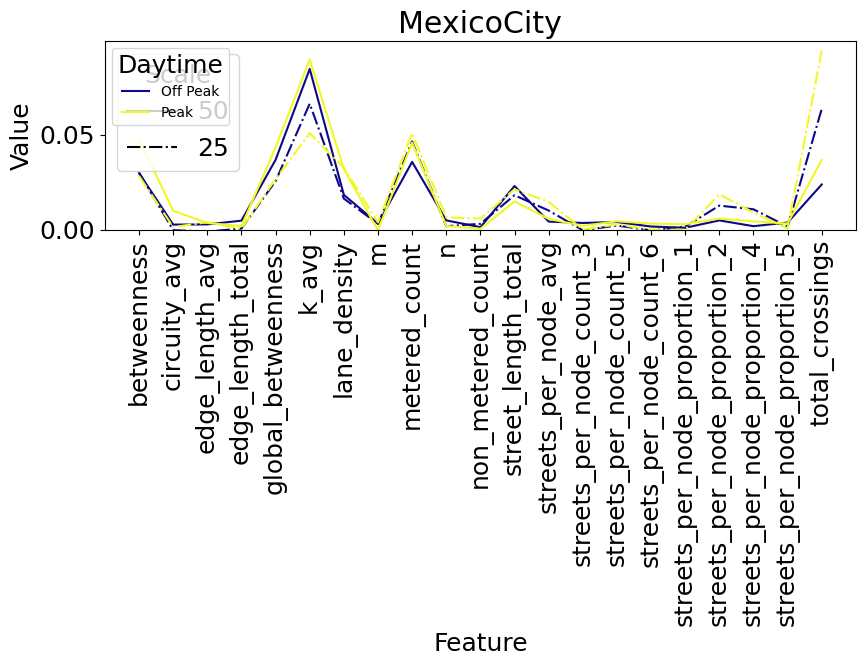

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


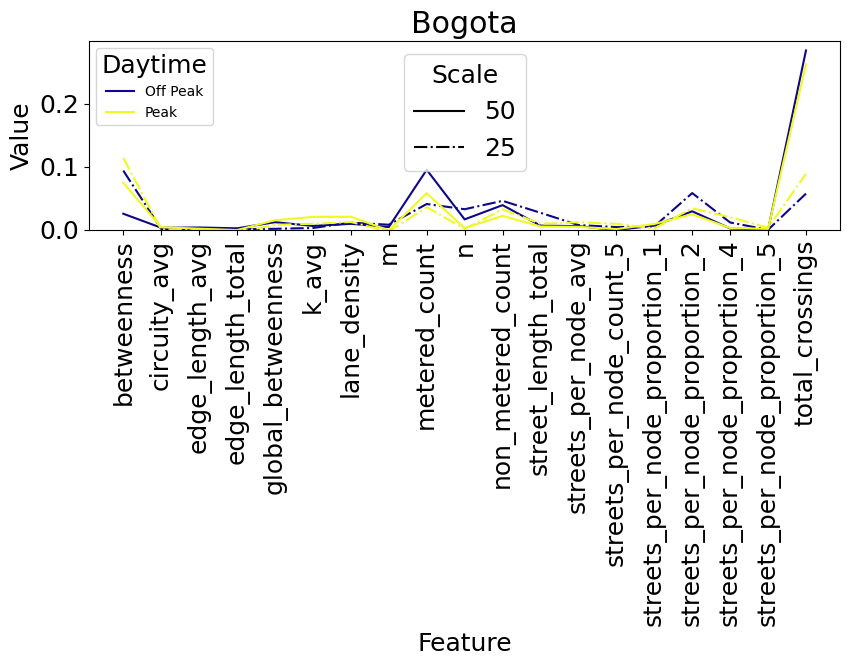

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


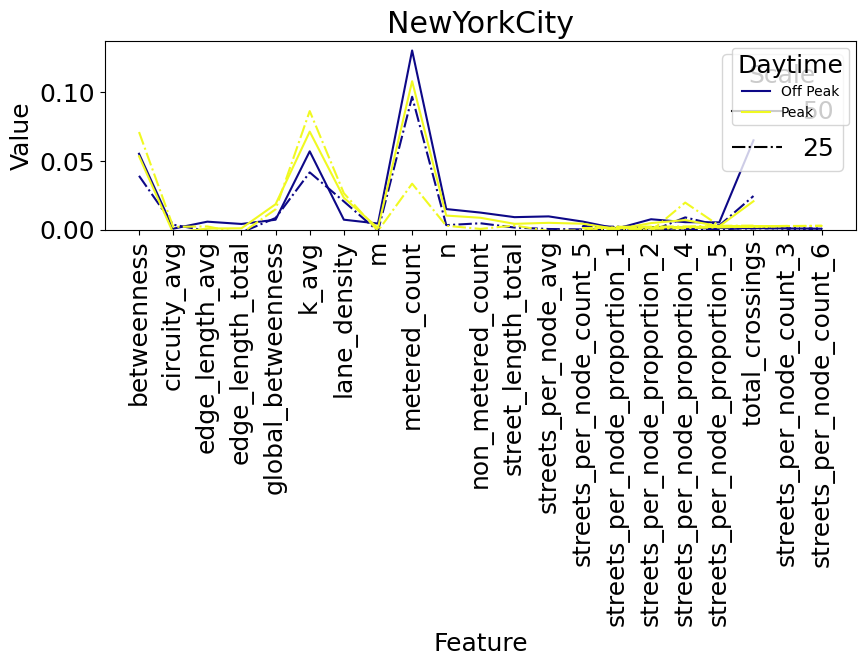

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


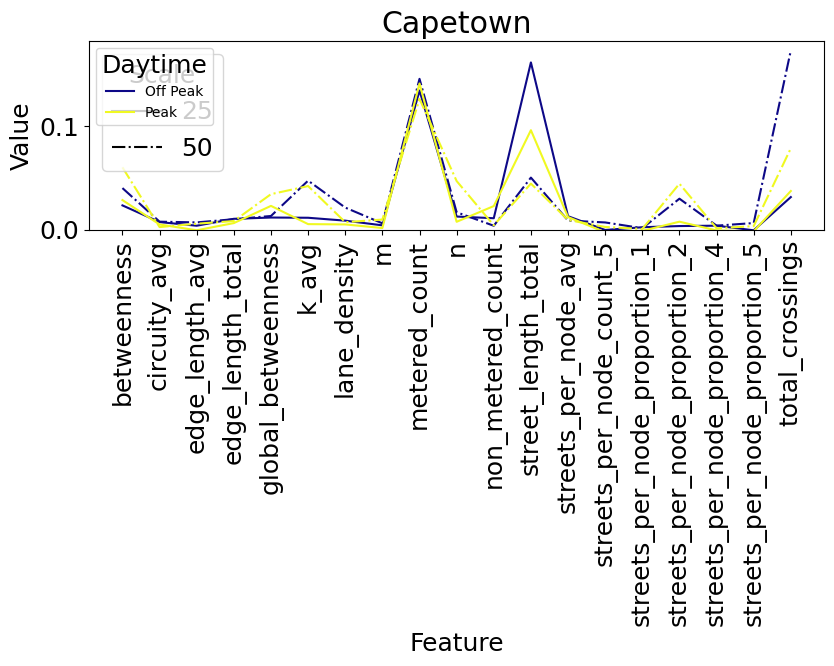

Aggregating over ['CityName', 'TOD', 'Marker', 'PlotCounter']


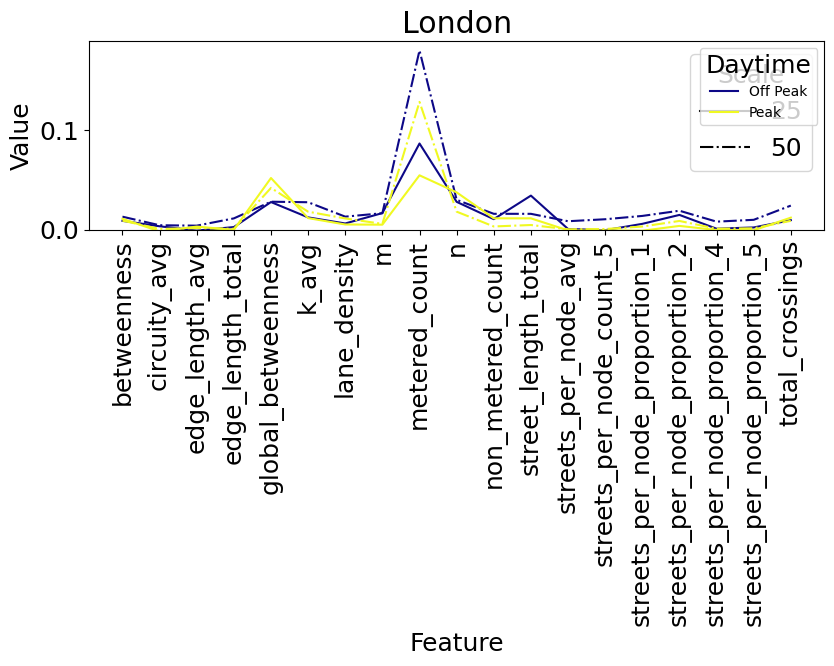

In [74]:
import pandas as pd

cities = [
    "Singapore", "Zurich", "Mumbai", "Auckland", "Istanbul", 
    "MexicoCity", "Bogota", "NewYorkCity", "Capetown", "London"
]

# Extract the header from mean_/ max three_scales.csv
with open("max_three_scales.csv", 'r') as main_file:
    header = main_file.readline().strip()

for city in cities:
    city_file = f"{city}_data.csv"
    
    # Extract relevant rows for the city
    with open("max_three_scales.csv", 'r') as main_file, open(city_file, 'w') as city_specific:
        for line in main_file:
            if city in line or header in line:
                city_specific.write(line)
    
    # Read the city-specific data into pandas
    data = pd.read_csv(city_file)
    
    # Update and sort data, then plot
    data["daytime"] = data["TOD"].apply(new_datetime)
    sorted_data = data.sort_values("Value")
    plot_configurations(sorted_data, col_xaxis="Feature", compare_col="daytime", compare_second_level="Scale", title=city)
